In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT = '/content/drive/MyDrive/A5/Mémoire/notebooks'
import sys
sys.path.append(ROOT)

# LSTM

## Objectif

L'objectif de ce notebook est d'effectuer nos prédictions à l'aide d'une régression à l'aide d'un LSTM.

## Import des librairies

In [ ]:
import os  # for path dirs and files
import tqdm  # progress bar


# to deal with data
import numpy as np
import pandas as pd

# plot the results
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

import keras
import sklearn.model_selection

from dataset import Dataset

## Import du dataset

Dans le notebook précédent numéro 3, nous avons créé une classe dataset pour simplifier les traitement. On peut donc l'importer.

In [ ]:
# import the dataset
dataset = Dataset(os.path.join(ROOT, 'data', 'data_optimized.csv'))
print(f'\nLength of the full dataset: {len(dataset)}\n')

Import file...
Convert day to date...
Convert columns to list...

Length of the full dataset: 225208



Pour plus d'homogénéïté, nous standardiserons les données avec:
$$
\tilde{R_{t}} = \frac{R_{t} - \mu}{\sigma}
$$

$$
\mu = \frac{1}{240}\sum_{m=1}^{240} R_{0-m}
$$

$$
\sigma = \frac{1}{240}\sum_{m=1}^{240} (R_{0-m} - \mu)
$$

In [ ]:
%%time
tqdm.tqdm.pandas()

print('Compute mu (mean)...')
dataset.df['mu'] = dataset.df.progress_apply(lambda row: np.mean(row['look_back_days']), axis=1)

print('Compute sigma (standard deviation)...')
dataset.df['sigma'] = dataset.df.progress_apply(lambda row: np.std(row['look_back_days']), axis=1)

print('Compute the standardized rate of return for target')
dataset.df['return'] = dataset.df.progress_apply(lambda row: (row['return'] - row['mu'])/row['sigma'], axis=1)



print('Compute the standardized rate of return in features...')
dataset.df['look_back_days'] = dataset.df.progress_apply(
    lambda row: list((np.array(row['look_back_days']) - row['mu']) / row['sigma'])
    if row['look_back_days'] == row['look_back_days'] else np.nan, 
    axis=1
)

dataset.df


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 0/225208 [00:00<?, ?it/s]

Compute mu (mean)...


  0%|          | 0/225208 [00:00<?, ?it/s]

Compute sigma (standard deviation)...


  0%|          | 0/225208 [00:00<?, ?it/s]

Compute the standardized rate of return for target


  0%|          | 0/225208 [00:00<?, ?it/s]

Compute the standardized rate of return in features...


100%|██████████| 225208/225208 [00:16<00:00, 13265.28it/s]

CPU times: user 43.8 s, sys: 1.29 s, total: 45.1 s
Wall time: 45.1 s


Et on peut faire le split train/validation/test

In [ ]:
# split the dataset
training_dataset, validation_dataset, test_dataset = dataset.split()
print(f'Training part: {len(training_dataset)}')
print(f'Validation part: {len(validation_dataset)}')
print(f'Test part: {len(test_dataset)}')

Training part: 25647
Validation part: 23817
Test part: 159839


## Modèle LSTM


On peut donc se faire une petite classe pour la régression LSTM sur la base de la précédente faite en notebook 3.


https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72
https://drive.google.com/drive/folders/1beMbjPLwADnllSuYqHY5plv4G-SXqx72



In [ ]:
class LSTM:
    
    def __init__(self, filters=8, kernel_stride=3, units=8, *args, **kwargs):
        # give a name to the model
        self.name = 'lstm'
        self.model = keras.models.Sequential([
            # keras.layers.LSTM(units, return_sequences=True, input_shape=(240, 1,)),
            # keras.layers.Dropout(0.1),
            # keras.layers.LSTM(units, return_sequences=True),
            # keras.layers.Dropout(0.1),
            keras.layers.Conv1D(filters=filters, kernel_size=kernel_stride, strides=kernel_stride, activation='relu', input_shape=(240, 1,)),
            keras.layers.LSTM(units),
            keras.layers.Dense(1)
        ])
        optimizer = keras.optimizers.RMSprop(lr=5e-4)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
        self.early_stopping = keras.callbacks.EarlyStopping(patience=3)

    def __call__(self, X):
        # prediction on the feature
        X = np.array(X)[..., np.newaxis] 
        pred = self.model.predict(np.array([X]))[0, 0]
        
        return pred
    
    def fit_dataset(self, training_dataset, validation_dataset):
        df = training_dataset.df.dropna()
        X_train = np.array(df['look_back_days'].tolist())[..., np.newaxis]
        y_train = np.array(df['return'].tolist())
        df = validation_dataset.df.dropna()
        X_val = np.array(df['look_back_days'].tolist())[..., np.newaxis]
        y_val = np.array(df['return'].tolist())
        self.model.fit(
            X_train, y_train, 
            shuffle=True,
            validation_data=(X_val, y_val),
            callbacks=[self.early_stopping],
            batch_size=32,
            epochs=1000,
            verbose=1
        )
    
    def valid_dataset(self, dataset):
        df = dataset.df.dropna()
        X = np.array(df['look_back_days'].tolist())[..., np.newaxis]
        y = np.array(df['return'].tolist())
        return self.model.predict(X)[:, 0], y
    
    
    def _predict_row(self, row):
        
        # predict the row only if it is not Nan of course
        if row.look_back_days != row.look_back_days:
            return np.nan
        else:
            return self.__call__(row.look_back_days)
        
    def predict_all_dataset(self, dataset, progress_bar=True):
        
        # get the primary keys (pair and day) and info (return and set) from the dataset
        predictions_df = pd.DataFrame(dataset.df[['pair', 'day', 'return', 'set']])
        
        # run the prediction all along the dataset and return it as a dataframe of predictions
        if progress_bar:
            tqdm.tqdm.pandas()
            predictions_df[self.name] = dataset.df.progress_apply(self._predict_row, axis=1)
        else:
            predictions_df[self.name] = dataset.df.apply(self._predict_row, axis=1)        
            
        return predictions_df
            
model = LSTM()
model.model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 80, 8)             32        
_________________________________________________________________
lstm_30 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 9         
Total params: 585
Trainable params: 585
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 8s 8ms/step - loss: 1.0587 - mse: 1.0587 - val_loss: 1.1325 - val_mse: 1.1325
Epoch 2/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0559 - mse: 1.0559 - val_loss: 1.1322 - val_mse: 1.1322
Epoch 3/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0810 - mse: 1.0810 - val_loss: 1.1320 - val_mse: 1.1320
Epoch 4/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0757 - mse: 1.0757 - val_loss: 1.1318 - val_mse: 1.1318
Epoch 5/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.1043 - mse: 1.1043 - val_loss: 1.1317 - val_mse: 1.1317
Epoch 6/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0669 - mse: 1.0669 - val_loss: 1.1327 - val_mse: 1.1327
Epoch 7/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0633 - mse: 1.0633 - val_loss: 1.1315 - val_mse: 1.1315
Epoch 8/1000
802/802 [==============================] - 6s 7ms

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 8s 8ms/step - loss: 1.0815 - mse: 1.0815 - val_loss: 1.1321 - val_mse: 1.1321
Epoch 2/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0727 - mse: 1.0727 - val_loss: 1.1389 - val_mse: 1.1389
Epoch 3/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0754 - mse: 1.0754 - val_loss: 1.1313 - val_mse: 1.1313
Epoch 4/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0775 - mse: 1.0775 - val_loss: 1.1308 - val_mse: 1.1308
Epoch 5/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0720 - mse: 1.0720 - val_loss: 1.1307 - val_mse: 1.1307
Epoch 6/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0901 - mse: 1.0901 - val_loss: 1.1316 - val_mse: 1.1316
Epoch 7/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0588 - mse: 1.0588 - val_loss: 1.1304 - val_mse: 1.1304
Epoch 8/1000
802/802 [==============================] - 6s 7ms

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 21s 9ms/step - loss: 1.0997 - mse: 1.0997 - val_loss: 1.1330 - val_mse: 1.1330
Epoch 2/1000
802/802 [==============================] - 7s 9ms/step - loss: 1.0800 - mse: 1.0800 - val_loss: 1.1317 - val_mse: 1.1317
Epoch 3/1000
802/802 [==============================] - 7s 9ms/step - loss: 1.0523 - mse: 1.0523 - val_loss: 1.1337 - val_mse: 1.1337
Epoch 4/1000
802/802 [==============================] - 7s 9ms/step - loss: 1.1064 - mse: 1.1064 - val_loss: 1.1329 - val_mse: 1.1329
Epoch 5/1000
802/802 [==============================] - 7s 9ms/step - loss: 1.0686 - mse: 1.0686 - val_loss: 1.1318 - val_mse: 1.1318
Parameters: {'filters': 8, 'kernel_stride': 3, 'units': 128}
	RMSE: 0.5658822641810768



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 7s 7ms/step - loss: 1.0907 - mse: 1.0907 - val_loss: 1.1335 - val_mse: 1.1335
Epoch 2/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0844 - mse: 1.0844 - val_loss: 1.1318 - val_mse: 1.1318
Epoch 3/1000
802/802 [==============================] - 6s 8ms/step - loss: 1.0828 - mse: 1.0828 - val_loss: 1.1313 - val_mse: 1.1313
Epoch 4/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0829 - mse: 1.0829 - val_loss: 1.1317 - val_mse: 1.1317
Epoch 5/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0542 - mse: 1.0542 - val_loss: 1.1329 - val_mse: 1.1329
Epoch 6/1000
802/802 [==============================] - 6s 8ms/step - loss: 1.0667 - mse: 1.0667 - val_loss: 1.1315 - val_mse: 1.1315
Parameters: {'filters': 8, 'kernel_stride': 5, 'units': 8}
	RMSE: 0.5657571211236194



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 7s 7ms/step - loss: 1.0931 - mse: 1.0931 - val_loss: 1.1333 - val_mse: 1.1333
Epoch 2/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0729 - mse: 1.0729 - val_loss: 1.1317 - val_mse: 1.1317
Epoch 3/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0466 - mse: 1.0466 - val_loss: 1.1328 - val_mse: 1.1328
Epoch 4/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.1073 - mse: 1.1073 - val_loss: 1.1314 - val_mse: 1.1314
Epoch 5/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0669 - mse: 1.0669 - val_loss: 1.1324 - val_mse: 1.1324
Epoch 6/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0726 - mse: 1.0726 - val_loss: 1.1319 - val_mse: 1.1319
Epoch 7/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0601 - mse: 1.0601 - val_loss: 1.1319 - val_mse: 1.1319
Parameters: {'filters': 8, 'kernel_stride': 5, 'units': 32}
	R

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 9s 7ms/step - loss: 1.0895 - mse: 1.0895 - val_loss: 1.1315 - val_mse: 1.1315
Epoch 2/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0857 - mse: 1.0857 - val_loss: 1.1315 - val_mse: 1.1315
Epoch 3/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0729 - mse: 1.0729 - val_loss: 1.1314 - val_mse: 1.1314
Epoch 4/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0937 - mse: 1.0937 - val_loss: 1.1319 - val_mse: 1.1319
Epoch 5/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0745 - mse: 1.0745 - val_loss: 1.1314 - val_mse: 1.1314
Epoch 6/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0991 - mse: 1.0991 - val_loss: 1.1310 - val_mse: 1.1310
Epoch 7/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0740 - mse: 1.0740 - val_loss: 1.1310 - val_mse: 1.1310
Epoch 8/1000
802/802 [==============================] - 5s 7ms

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 8s 8ms/step - loss: 1.0713 - mse: 1.0713 - val_loss: 1.1345 - val_mse: 1.1345
Epoch 2/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0633 - mse: 1.0633 - val_loss: 1.1335 - val_mse: 1.1335
Epoch 3/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0829 - mse: 1.0829 - val_loss: 1.1328 - val_mse: 1.1328
Epoch 4/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.1080 - mse: 1.1080 - val_loss: 1.1326 - val_mse: 1.1326
Epoch 5/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0827 - mse: 1.0827 - val_loss: 1.1343 - val_mse: 1.1343
Epoch 6/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0866 - mse: 1.0866 - val_loss: 1.1325 - val_mse: 1.1325
Epoch 7/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0809 - mse: 1.0809 - val_loss: 1.1331 - val_mse: 1.1331
Epoch 8/1000
802/802 [==============================] - 6s 7ms

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 7s 6ms/step - loss: 1.0651 - mse: 1.0651 - val_loss: 1.1310 - val_mse: 1.1310
Epoch 2/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0819 - mse: 1.0819 - val_loss: 1.1308 - val_mse: 1.1308
Epoch 3/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0832 - mse: 1.0832 - val_loss: 1.1317 - val_mse: 1.1317
Epoch 4/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0908 - mse: 1.0908 - val_loss: 1.1314 - val_mse: 1.1314
Epoch 5/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0787 - mse: 1.0787 - val_loss: 1.1306 - val_mse: 1.1306
Epoch 6/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0707 - mse: 1.0707 - val_loss: 1.1305 - val_mse: 1.1305
Epoch 7/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0702 - mse: 1.0702 - val_loss: 1.1306 - val_mse: 1.1306
Epoch 8/1000
802/802 [==============================] - 5s 6ms

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 8s 8ms/step - loss: 1.0823 - mse: 1.0823 - val_loss: 1.1326 - val_mse: 1.1326
Epoch 2/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0578 - mse: 1.0578 - val_loss: 1.1319 - val_mse: 1.1319
Epoch 3/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0773 - mse: 1.0773 - val_loss: 1.1320 - val_mse: 1.1320
Epoch 4/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0651 - mse: 1.0651 - val_loss: 1.1318 - val_mse: 1.1318
Epoch 5/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0714 - mse: 1.0714 - val_loss: 1.1325 - val_mse: 1.1325
Epoch 6/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0811 - mse: 1.0811 - val_loss: 1.1331 - val_mse: 1.1331
Epoch 7/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0653 - mse: 1.0653 - val_loss: 1.1328 - val_mse: 1.1328
Parameters: {'filters': 8, 'kernel_stride': 7, 'units': 128}
	

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 8s 8ms/step - loss: 1.0567 - mse: 1.0567 - val_loss: 1.1327 - val_mse: 1.1327
Epoch 2/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0874 - mse: 1.0874 - val_loss: 1.1321 - val_mse: 1.1321
Epoch 3/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0908 - mse: 1.0908 - val_loss: 1.1314 - val_mse: 1.1314
Epoch 4/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0662 - mse: 1.0662 - val_loss: 1.1325 - val_mse: 1.1325
Epoch 5/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0904 - mse: 1.0904 - val_loss: 1.1323 - val_mse: 1.1323
Epoch 6/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0579 - mse: 1.0579 - val_loss: 1.1316 - val_mse: 1.1316
Parameters: {'filters': 32, 'kernel_stride': 3, 'units': 8}
	RMSE: 0.5658236112464282



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 8s 8ms/step - loss: 1.0860 - mse: 1.0860 - val_loss: 1.1374 - val_mse: 1.1374
Epoch 2/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0764 - mse: 1.0764 - val_loss: 1.1322 - val_mse: 1.1322
Epoch 3/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0830 - mse: 1.0830 - val_loss: 1.1326 - val_mse: 1.1326
Epoch 4/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0853 - mse: 1.0853 - val_loss: 1.1325 - val_mse: 1.1325
Epoch 5/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0642 - mse: 1.0642 - val_loss: 1.1314 - val_mse: 1.1314
Epoch 6/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0682 - mse: 1.0682 - val_loss: 1.1333 - val_mse: 1.1333
Epoch 7/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.1116 - mse: 1.1116 - val_loss: 1.1314 - val_mse: 1.1314
Epoch 8/1000
802/802 [==============================] - 6s 7ms

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 9s 9ms/step - loss: 1.0894 - mse: 1.0894 - val_loss: 1.1321 - val_mse: 1.1321
Epoch 2/1000
802/802 [==============================] - 7s 9ms/step - loss: 1.0868 - mse: 1.0868 - val_loss: 1.1323 - val_mse: 1.1323
Epoch 3/1000
802/802 [==============================] - 7s 9ms/step - loss: 1.0823 - mse: 1.0823 - val_loss: 1.1324 - val_mse: 1.1324
Epoch 4/1000
802/802 [==============================] - 7s 9ms/step - loss: 1.0569 - mse: 1.0569 - val_loss: 1.1324 - val_mse: 1.1324
Parameters: {'filters': 32, 'kernel_stride': 3, 'units': 128}
	RMSE: 0.5662058964887905



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 8s 7ms/step - loss: 1.0780 - mse: 1.0780 - val_loss: 1.1340 - val_mse: 1.1340
Epoch 2/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0642 - mse: 1.0642 - val_loss: 1.1327 - val_mse: 1.1327
Epoch 3/1000
802/802 [==============================] - 6s 8ms/step - loss: 1.0737 - mse: 1.0737 - val_loss: 1.1329 - val_mse: 1.1329
Epoch 4/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0812 - mse: 1.0812 - val_loss: 1.1329 - val_mse: 1.1329
Epoch 5/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0813 - mse: 1.0813 - val_loss: 1.1338 - val_mse: 1.1338
Parameters: {'filters': 32, 'kernel_stride': 5, 'units': 8}
	RMSE: 0.5668769394461548



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 7s 7ms/step - loss: 1.0713 - mse: 1.0713 - val_loss: 1.1321 - val_mse: 1.1321
Epoch 2/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0927 - mse: 1.0927 - val_loss: 1.1326 - val_mse: 1.1326
Epoch 3/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0807 - mse: 1.0807 - val_loss: 1.1318 - val_mse: 1.1318
Epoch 4/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0794 - mse: 1.0794 - val_loss: 1.1308 - val_mse: 1.1308
Epoch 5/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0796 - mse: 1.0796 - val_loss: 1.1313 - val_mse: 1.1313
Epoch 6/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0746 - mse: 1.0746 - val_loss: 1.1345 - val_mse: 1.1345
Epoch 7/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0705 - mse: 1.0705 - val_loss: 1.1326 - val_mse: 1.1326
Parameters: {'filters': 32, 'kernel_stride': 5, 'units': 32}
	

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 8s 7ms/step - loss: 1.0890 - mse: 1.0890 - val_loss: 1.1345 - val_mse: 1.1345
Epoch 2/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0515 - mse: 1.0515 - val_loss: 1.1355 - val_mse: 1.1355
Epoch 3/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0799 - mse: 1.0799 - val_loss: 1.1323 - val_mse: 1.1323
Epoch 4/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0726 - mse: 1.0726 - val_loss: 1.1325 - val_mse: 1.1325
Epoch 5/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0928 - mse: 1.0928 - val_loss: 1.1322 - val_mse: 1.1322
Epoch 6/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0666 - mse: 1.0666 - val_loss: 1.1313 - val_mse: 1.1313
Epoch 7/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0661 - mse: 1.0661 - val_loss: 1.1316 - val_mse: 1.1316
Epoch 8/1000
802/802 [==============================] - 5s 7ms

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 9s 9ms/step - loss: 1.1041 - mse: 1.1041 - val_loss: 1.1337 - val_mse: 1.1337
Epoch 2/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0893 - mse: 1.0893 - val_loss: 1.1330 - val_mse: 1.1330
Epoch 3/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0822 - mse: 1.0822 - val_loss: 1.1326 - val_mse: 1.1326
Epoch 4/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0688 - mse: 1.0688 - val_loss: 1.1310 - val_mse: 1.1310
Epoch 5/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0576 - mse: 1.0576 - val_loss: 1.1315 - val_mse: 1.1315
Epoch 6/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0732 - mse: 1.0732 - val_loss: 1.1314 - val_mse: 1.1314
Epoch 7/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0703 - mse: 1.0703 - val_loss: 1.1317 - val_mse: 1.1317
Parameters: {'filters': 32, 'kernel_stride': 7, 'units': 8}
	R

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 7s 7ms/step - loss: 1.0956 - mse: 1.0956 - val_loss: 1.1311 - val_mse: 1.1311
Epoch 2/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0660 - mse: 1.0660 - val_loss: 1.1313 - val_mse: 1.1313
Epoch 3/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0648 - mse: 1.0648 - val_loss: 1.1314 - val_mse: 1.1314
Epoch 4/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0939 - mse: 1.0939 - val_loss: 1.1322 - val_mse: 1.1322
Parameters: {'filters': 32, 'kernel_stride': 7, 'units': 32}
	RMSE: 0.5660864150432091



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 7s 7ms/step - loss: 1.0841 - mse: 1.0841 - val_loss: 1.1320 - val_mse: 1.1320
Epoch 2/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0690 - mse: 1.0690 - val_loss: 1.1310 - val_mse: 1.1310
Epoch 3/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0693 - mse: 1.0693 - val_loss: 1.1308 - val_mse: 1.1308
Epoch 4/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0827 - mse: 1.0827 - val_loss: 1.1326 - val_mse: 1.1326
Epoch 5/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0771 - mse: 1.0771 - val_loss: 1.1315 - val_mse: 1.1315
Epoch 6/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0693 - mse: 1.0693 - val_loss: 1.1334 - val_mse: 1.1334
Parameters: {'filters': 32, 'kernel_stride': 7, 'units': 128}
	RMSE: 0.5666750439301209



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 8s 8ms/step - loss: 1.0768 - mse: 1.0768 - val_loss: 1.1322 - val_mse: 1.1322
Epoch 2/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0869 - mse: 1.0869 - val_loss: 1.1320 - val_mse: 1.1320
Epoch 3/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0792 - mse: 1.0792 - val_loss: 1.1313 - val_mse: 1.1313
Epoch 4/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0488 - mse: 1.0488 - val_loss: 1.1323 - val_mse: 1.1323
Epoch 5/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0840 - mse: 1.0840 - val_loss: 1.1315 - val_mse: 1.1315
Epoch 6/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0732 - mse: 1.0732 - val_loss: 1.1326 - val_mse: 1.1326
Parameters: {'filters': 128, 'kernel_stride': 3, 'units': 8}
	RMSE: 0.5662829594269324



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 9s 8ms/step - loss: 1.0610 - mse: 1.0610 - val_loss: 1.1313 - val_mse: 1.1313
Epoch 2/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0853 - mse: 1.0853 - val_loss: 1.1322 - val_mse: 1.1322
Epoch 3/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0845 - mse: 1.0845 - val_loss: 1.1325 - val_mse: 1.1325
Epoch 4/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0767 - mse: 1.0767 - val_loss: 1.1318 - val_mse: 1.1318
Parameters: {'filters': 128, 'kernel_stride': 3, 'units': 32}
	RMSE: 0.5658767751959675



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 9s 9ms/step - loss: 1.0640 - mse: 1.0640 - val_loss: 1.1309 - val_mse: 1.1309
Epoch 2/1000
802/802 [==============================] - 7s 9ms/step - loss: 1.0978 - mse: 1.0978 - val_loss: 1.1320 - val_mse: 1.1320
Epoch 3/1000
802/802 [==============================] - 7s 9ms/step - loss: 1.0664 - mse: 1.0664 - val_loss: 1.1314 - val_mse: 1.1314
Epoch 4/1000
802/802 [==============================] - 7s 9ms/step - loss: 1.0543 - mse: 1.0543 - val_loss: 1.1338 - val_mse: 1.1338
Parameters: {'filters': 128, 'kernel_stride': 3, 'units': 128}
	RMSE: 0.5669220399991095



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 7s 7ms/step - loss: 1.0520 - mse: 1.0520 - val_loss: 1.1332 - val_mse: 1.1332
Epoch 2/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0696 - mse: 1.0696 - val_loss: 1.1316 - val_mse: 1.1316
Epoch 3/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0806 - mse: 1.0806 - val_loss: 1.1331 - val_mse: 1.1331
Epoch 4/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0764 - mse: 1.0764 - val_loss: 1.1311 - val_mse: 1.1311
Epoch 5/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0691 - mse: 1.0691 - val_loss: 1.1321 - val_mse: 1.1321
Epoch 6/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0762 - mse: 1.0762 - val_loss: 1.1309 - val_mse: 1.1309
Epoch 7/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0873 - mse: 1.0873 - val_loss: 1.1326 - val_mse: 1.1326
Epoch 8/1000
802/802 [==============================] - 5s 7ms

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 8s 7ms/step - loss: 1.0775 - mse: 1.0775 - val_loss: 1.1323 - val_mse: 1.1323
Epoch 2/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0635 - mse: 1.0635 - val_loss: 1.1310 - val_mse: 1.1310
Epoch 3/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0572 - mse: 1.0572 - val_loss: 1.1311 - val_mse: 1.1311
Epoch 4/1000
802/802 [==============================] - 6s 8ms/step - loss: 1.0728 - mse: 1.0728 - val_loss: 1.1322 - val_mse: 1.1322
Epoch 5/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0631 - mse: 1.0631 - val_loss: 1.1324 - val_mse: 1.1324
Parameters: {'filters': 128, 'kernel_stride': 5, 'units': 32}
	RMSE: 0.5661795186915952



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 8s 7ms/step - loss: 1.0749 - mse: 1.0749 - val_loss: 1.1326 - val_mse: 1.1326
Epoch 2/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0613 - mse: 1.0613 - val_loss: 1.1336 - val_mse: 1.1336
Epoch 3/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0889 - mse: 1.0889 - val_loss: 1.1332 - val_mse: 1.1332
Epoch 4/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0783 - mse: 1.0783 - val_loss: 1.1323 - val_mse: 1.1323
Epoch 5/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0584 - mse: 1.0584 - val_loss: 1.1314 - val_mse: 1.1314
Epoch 6/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0637 - mse: 1.0637 - val_loss: 1.1321 - val_mse: 1.1321
Epoch 7/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0673 - mse: 1.0673 - val_loss: 1.1342 - val_mse: 1.1342
Epoch 8/1000
802/802 [==============================] - 6s 7ms

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 8s 8ms/step - loss: 1.0919 - mse: 1.0919 - val_loss: 1.1316 - val_mse: 1.1316
Epoch 2/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0871 - mse: 1.0871 - val_loss: 1.1316 - val_mse: 1.1316
Epoch 3/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0720 - mse: 1.0720 - val_loss: 1.1316 - val_mse: 1.1316
Epoch 4/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0429 - mse: 1.0429 - val_loss: 1.1327 - val_mse: 1.1327
Epoch 5/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0990 - mse: 1.0990 - val_loss: 1.1307 - val_mse: 1.1307
Epoch 6/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0897 - mse: 1.0897 - val_loss: 1.1310 - val_mse: 1.1310
Epoch 7/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0860 - mse: 1.0860 - val_loss: 1.1305 - val_mse: 1.1305
Epoch 8/1000
802/802 [==============================] - 6s 7ms

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 9s 8ms/step - loss: 1.0826 - mse: 1.0826 - val_loss: 1.1322 - val_mse: 1.1322
Epoch 2/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0841 - mse: 1.0841 - val_loss: 1.1313 - val_mse: 1.1313
Epoch 3/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0668 - mse: 1.0668 - val_loss: 1.1306 - val_mse: 1.1306
Epoch 4/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0791 - mse: 1.0791 - val_loss: 1.1324 - val_mse: 1.1324
Epoch 5/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0642 - mse: 1.0642 - val_loss: 1.1324 - val_mse: 1.1324
Epoch 6/1000
802/802 [==============================] - 6s 7ms/step - loss: 1.0575 - mse: 1.0575 - val_loss: 1.1334 - val_mse: 1.1334
Parameters: {'filters': 128, 'kernel_stride': 7, 'units': 32}
	RMSE: 0.5667239775965904



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 7s 7ms/step - loss: 1.0656 - mse: 1.0656 - val_loss: 1.1380 - val_mse: 1.1380
Epoch 2/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0827 - mse: 1.0827 - val_loss: 1.1302 - val_mse: 1.1302
Epoch 3/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0899 - mse: 1.0899 - val_loss: 1.1324 - val_mse: 1.1324
Epoch 4/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0655 - mse: 1.0655 - val_loss: 1.1324 - val_mse: 1.1324
Epoch 5/1000
802/802 [==============================] - 5s 6ms/step - loss: 1.0692 - mse: 1.0692 - val_loss: 1.1328 - val_mse: 1.1328
Parameters: {'filters': 128, 'kernel_stride': 7, 'units': 128}
	RMSE: 0.5664065097275223



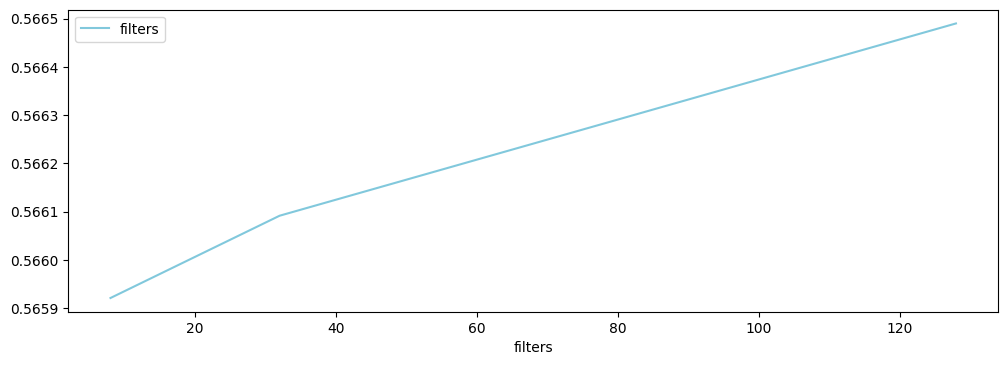

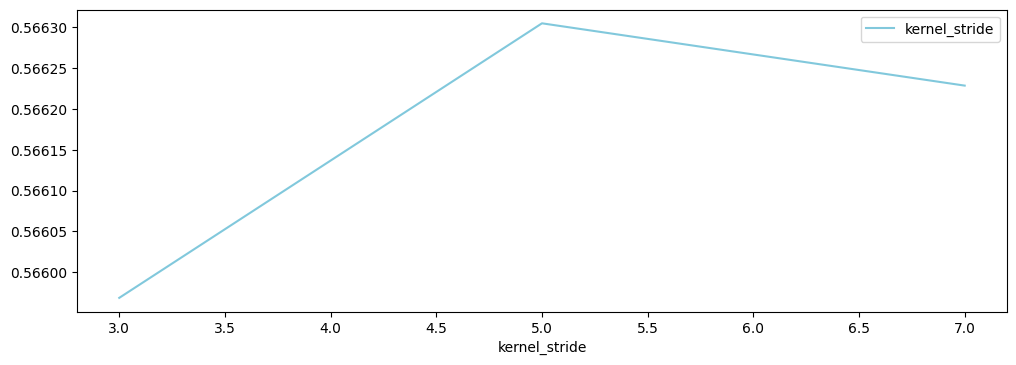

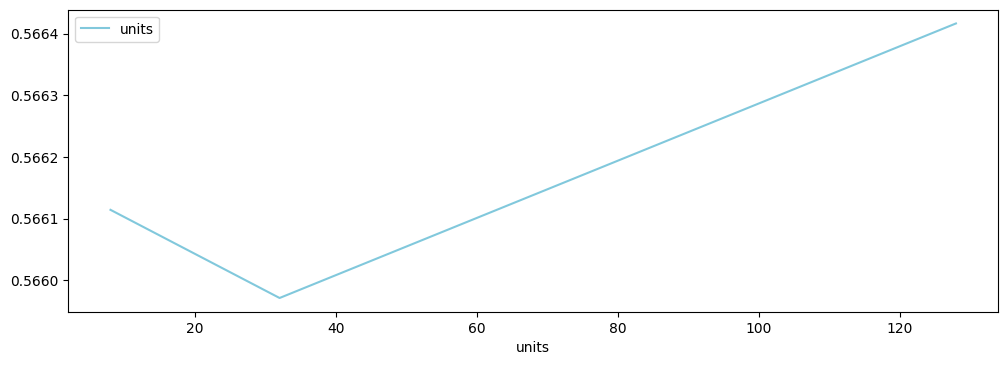

,filters,kernel_stride,rmse,units
14,32.0,5.0,0.565389,128.0
1,8.0,3.0,0.565473,32.0
7,8.0,7.0,0.565499,32.0
0,8.0,3.0,0.565621,8.0
10,32.0,3.0,0.565629,32.0
24,128.0,7.0,0.565680,8.0
3,8.0,5.0,0.565757,8.0
9,32.0,3.0,0.565824,8.0
15,32.0,7.0,0.565828,8.0
19,128.0,3.0,0.565877,32.0


In [ ]:
RE_RUN = True

param_grid = {
    'filters': [8, 32, 128],    
    'kernel_stride': [3, 5, 7],
    'units': [8, 32, 128]
}

results_df = pd.DataFrame()
if RE_RUN:
    for param in sklearn.model_selection.ParameterGrid(param_grid):

        model = LSTM(**param)
        
        # fit with the training set and get the rmse error on the validation set 
        model.fit_dataset(training_dataset, validation_dataset)
        pred, y = model.valid_dataset(validation_dataset)
        rmse = (((pred - y)**2)**1/2).mean()
        
        # save the results
        print(f'Parameters: {param}\n\tRMSE: {rmse}\n')
        param['rmse'] = rmse
        results_df = results_df.append(param, ignore_index=True)
else:
    # these are save results copy paste from the run
    save_results = [0.565621  , 0.56547253, 0.56588226, 0.56575712, 0.56596859,
                    0.56592883, 0.5667709 , 0.56549852, 0.56638717, 0.56582361,
                    0.56562931, 0.5662059 , 0.56687694, 0.56630727, 0.56538901,
                    0.56582832, 0.56608642, 0.56667504, 0.56628296, 0.56587678,
                    0.56692204, 0.56638729, 0.56617952, 0.56794983, 0.56568039,
                    0.56672398, 0.56640651]

    results_df = pd.DataFrame(sklearn.model_selection.ParameterGrid(param_grid))
    results_df['rmse'] = save_results

for param_name in param_grid.keys():
    # evaluation of the parameters thanks to the groupby --> mean 
    param_df= results_df.groupby(param_name).mean().reset_index()
    # set the kind of plot according to the type of the parameter
    kind = 'line' if np.array(param_df[param_name]).dtype == 'float64' else 'bar'
    # and plot
    param_df.plot(param_name, 'rmse', color='#0593ba', alpha=0.5, label=param_name, kind=kind)
    plt.legend()
    plt.show()
results_df.sort_values('rmse')


In [ ]:
results_df.rmse.values

array([0.565621  , 0.56547253, 0.56588226, 0.56575712, 0.56596859,
       0.56592883, 0.5667709 , 0.56549852, 0.56638717, 0.56582361,
       0.56562931, 0.5662059 , 0.56687694, 0.56630727, 0.56538901,
       0.56582832, 0.56608642, 0.56667504, 0.56628296, 0.56587678,
       0.56692204, 0.56638729, 0.56617952, 0.56794983, 0.56568039,
       0.56672398, 0.56640651])

In [ ]:
model = LSTM(filters=32, kernel_stride=5, units=128)

model.fit_dataset(training_dataset, validation_dataset)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
802/802 [==============================] - 8s 7ms/step - loss: 1.0744 - mse: 1.0744 - val_loss: 1.1337 - val_mse: 1.1337
Epoch 2/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0584 - mse: 1.0584 - val_loss: 1.1324 - val_mse: 1.1324
Epoch 3/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0981 - mse: 1.0981 - val_loss: 1.1344 - val_mse: 1.1344
Epoch 4/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0833 - mse: 1.0833 - val_loss: 1.1323 - val_mse: 1.1323
Epoch 5/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0691 - mse: 1.0691 - val_loss: 1.1316 - val_mse: 1.1316
Epoch 6/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0873 - mse: 1.0873 - val_loss: 1.1346 - val_mse: 1.1346
Epoch 7/1000
802/802 [==============================] - 5s 7ms/step - loss: 1.0742 - mse: 1.0742 - val_loss: 1.1361 - val_mse: 1.1361
Epoch 8/1000
802/802 [==============================] - 5s 7ms

## Prédiction sur tout le dataset et analyse

Maintenant que notre modèle est entrainé, on peut faire les prédictions sur tout le dataset. 

In [ ]:
# TRES LONG A FAIRE TOURNER, TU PEUX COMPARER AVEC LE RSME DEUX CELLULES PLUS HAUT C'EST SUFFISANT
# TRES LONG A FAIRE TOURNER, TU PEUX COMPARER AVEC LE RSME DEUX CELLULES PLUS HAUT C'EST SUFFISANT
# TRES LONG A FAIRE TOURNER, TU PEUX COMPARER AVEC LE RSME DEUX CELLULES PLUS HAUT C'EST SUFFISANT
# TRES LONG A FAIRE TOURNER, TU PEUX COMPARER AVEC LE RSME DEUX CELLULES PLUS HAUT C'EST SUFFISANT
predictions_df = model.predict_all_dataset(dataset)
predictions_df

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 225208/225208 [2:01:27<00:00, 30.90it/s]


,pair,day,return,set,lstm
0,AUDCAD,2007-10-23,NaN,unpredictable,NaN
1,AUDCAD,2007-10-24,NaN,unpredictable,NaN
2,AUDCAD,2007-10-25,NaN,unpredictable,NaN
3,AUDCAD,2007-10-26,NaN,unpredictable,NaN
4,AUDCAD,2007-10-29,NaN,unpredictable,NaN
...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.247127,test,0.102161
225204,ZARJPY,2020-12-28,0.412565,test,0.011432
225205,ZARJPY,2020-12-29,-0.189763,test,0.010211
225206,ZARJPY,2020-12-30,-0.605506,test,0.072499


A noter que l'on a transformé nos données en les normalisant.
Il faut donc pouvoir dénormaliser nos prédiction $\hat{\tilde{R_{0}}}$ tel que:

$$
\hat{R_{0}} = \hat{\tilde{R_{0}}} * \sigma + \mu
$$

Donc nous avons besoin de refaire la jointure avec le dataset pour nos prédictions

In [ ]:

predictions_df = predictions_df.merge(dataset.df[['pair', 'day', 'mu', 'sigma']], how='inner', on=['pair', 'day'])
predictions_df

,pair,day,return,set,lstm,mu,sigma
0,AUDCAD,2007-10-23,NaN,unpredictable,NaN,NaN,NaN
1,AUDCAD,2007-10-24,NaN,unpredictable,NaN,NaN,NaN
2,AUDCAD,2007-10-25,NaN,unpredictable,NaN,NaN,NaN
3,AUDCAD,2007-10-26,NaN,unpredictable,NaN,NaN,NaN
4,AUDCAD,2007-10-29,NaN,unpredictable,NaN,NaN,NaN
...,...,...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.247127,test,0.102161,-0.000015,0.011358
225204,ZARJPY,2020-12-28,0.412565,test,0.011432,-0.000017,0.011359
225205,ZARJPY,2020-12-29,-0.189763,test,0.010211,0.000041,0.011347
225206,ZARJPY,2020-12-30,-0.605506,test,0.072499,0.000081,0.011322


In [ ]:

print('Compute the un-standardized rate of return for target')
predictions_df['return'] = predictions_df.progress_apply(lambda row: row['return'] * row['sigma'] + row['mu'], axis=1)
print('Compute the un-standardized rate of return for prediction')
predictions_df[model.name] = predictions_df.progress_apply(lambda row: row[model.name] * row['sigma'] + row['mu'], axis=1)
predictions_df


  0%|          | 0/225208 [00:00<?, ?it/s]

Compute the un-standardized rate of return for target


  0%|          | 0/225208 [00:00<?, ?it/s]

Compute the un-standardized rate of return for prediction


100%|██████████| 225208/225208 [00:05<00:00, 41421.71it/s]


,pair,day,return,set,lstm,mu,sigma
0,AUDCAD,2007-10-23,NaN,unpredictable,NaN,NaN,NaN
1,AUDCAD,2007-10-24,NaN,unpredictable,NaN,NaN,NaN
2,AUDCAD,2007-10-25,NaN,unpredictable,NaN,NaN,NaN
3,AUDCAD,2007-10-26,NaN,unpredictable,NaN,NaN,NaN
4,AUDCAD,2007-10-29,NaN,unpredictable,NaN,NaN,NaN
...,...,...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test,0.001145,-0.000015,0.011358
225204,ZARJPY,2020-12-28,0.004670,test,0.000113,-0.000017,0.011359
225205,ZARJPY,2020-12-29,-0.002113,test,0.000157,0.000041,0.011347
225206,ZARJPY,2020-12-30,-0.006775,test,0.000902,0.000081,0.011322


Maintenant on peut afficher la distribution des prédictions en fonction des ground truth 

In [ ]:
def plot_scatter_and_hist(predictions_df, filter_set=None, color='#0593ba', label='', axes=None):

    # definition for set(s) to plot    
    if filter_set is not None: # no filter
        if isinstance(filter_set, str): # convert to list if it is string to be homogeneous
            filter_set = [filter_set]
        # make the filter on the set(s)
        predictions_df = predictions_df[predictions_df['set'].isin(filter_set)]
    # drop Nan values 
    predictions_df = predictions_df.dropna()

    # definitions for the axes
    if axes is None:
        # set the axes dimensions
        left, width = 0.1, 0.65
        bottom, height = 0.1, 0.65
        spacing = 0.005
        
        # compute their rectangle
        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom + height + spacing, width, 0.2]
        rect_histy = [left + width + spacing, bottom, 0.2, height]
        ax_scatter = plt.axes(rect_scatter)
        
        # create the axes
        ax_scatter.tick_params(direction='in', top=True, right=True)
        ax_histx = plt.axes(rect_histx)
        ax_histy = plt.axes(rect_histy)
        ax_histx.tick_params(direction='in', labelbottom=False)
        ax_histy.tick_params(direction='in', labelleft=False)
        
        ax_scatter.set_xlabel('True')
        ax_scatter.set_ylabel('Prediction')
        
        # add the zero's lines to be more comprehensive
        ax_scatter.axvline(x=0, color='#000000', alpha=0.3)
        ax_scatter.axhline(y=0, color='#000000', alpha=0.3)
        ax_histx.axvline(  x=0, color='#000000', alpha=0.3)
        ax_histy.axhline(  y=0, color='#000000', alpha=0.3)
    else:
        ax_scatter, ax_histx, ax_histy = axes
        

    # the scatter plot
    ax_scatter.scatter(predictions_df['return'], predictions_df[model.name], color=color, alpha=0.01)
    
    # the histograms
    bins = 100
    ax_histx.hist(predictions_df['return'], bins=bins, density=True, color=color, alpha=0.3, label=label)
    ax_histy.hist(predictions_df[model.name], bins=bins, density=True, color=color, alpha=0.3, orientation='horizontal')
    
    # set the limit on histograms to have its axis aligned to the scatter plot
    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    return ax_scatter, ax_histx, ax_histy
    

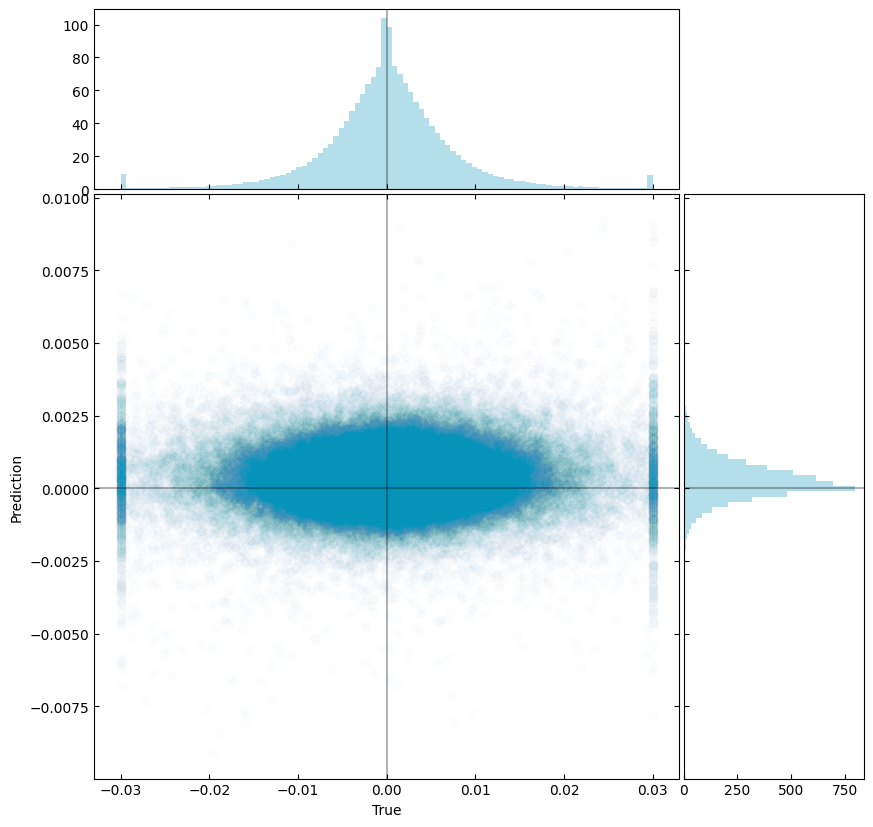

In [ ]:
plt.rcParams['figure.figsize'] = [9, 9]    
plot_scatter_and_hist(predictions_df)
plt.rcParams['figure.figsize'] = [12, 4]

pass

Il est encore pertinent de visualiser si la distribution des erreurs est normale ou non. Du moins, vérifier si elle est centrée en zéro et interpréter sont applatissement.

A noter que l'erreur est donnée par la formule suivante:

$error = \hat{R_{0}} - R_{0}$

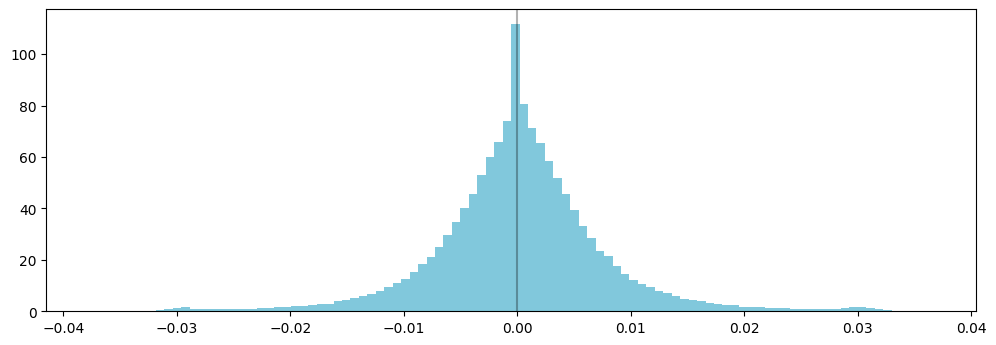

In [ ]:
error = predictions_df[model.name] - predictions_df['return']
plt.hist(error, bins=100, density=True, color='#0593ba', alpha=0.5)
plt.axvline(x=0, color='#000000', alpha=0.3)

pass

Et enfin, on peut s'attarder sur les métriques statistiques globales et par split de dataset

In [ ]:
pd.options.display.float_format = '{:.8f}'.format
error_table = error.agg(['mean', 'std', 'skew', 'kurt']).reset_index()
error_table

,index,0
0,mean,0.00018605
1,std,0.00752507
2,skew,0.07262359
3,kurt,3.28338679


In [ ]:
set_df = predictions_df[['set']]
set_df['error'] = error
pd.options.display.float_format = "{0:.8f}".format
error_table = set_df.groupby(['set']).agg({'error':['mean', 'std', pd.Series.skew, pd.Series.kurt]}).reset_index()
error_table

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


set      error                                 
                       mean        std       skew       kurt
0           test 0.00019392 0.00793400 0.07016650 3.02921869
1       training 0.00016206 0.00602349 0.08853239 2.55304488
2  unpredictable        nan        nan        nan        nan
3     validation 0.00015908 0.00600923 0.05394699 3.79178174

In [ ]:
pd.options.display.float_format = None

## Sauvegarde des données

Ne reste plus qu'à sauvegarder nos données. 

Pour cela, on reprend les fichier `results.csv` établit lors du notebook précédent et on y joint les nouvelles prédiction du modèle de ce notebook

In [ ]:
df = pd.read_csv(os.path.join(ROOT, 'data', 'results.csv'))  # read file
df['day'] = pd.to_datetime(df['day'])                       # convert the str days to dates

# can be useufl when reloaded
if model.name in df.columns:
    df = df.drop(columns=model.name)
df

,pair,day,return,set,naive,linear_regression,knn_regressor,rf_regressor,dnn
0,AUDCAD,2007-10-23,0.007541,unpredictable,NaN,NaN,NaN,NaN,NaN
1,AUDCAD,2007-10-24,0.003915,unpredictable,NaN,NaN,NaN,NaN,NaN
2,AUDCAD,2007-10-25,0.002523,unpredictable,NaN,NaN,NaN,NaN,NaN
3,AUDCAD,2007-10-26,0.005835,unpredictable,NaN,NaN,NaN,NaN,NaN
4,AUDCAD,2007-10-29,0.007962,unpredictable,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test,0.004251,0.000222,0.001476,-0.001028,-0.000169
225204,ZARJPY,2020-12-28,0.004670,test,-0.002822,-0.000062,0.003456,0.000891,0.001152
225205,ZARJPY,2020-12-29,-0.002113,test,0.004670,-0.000604,0.004920,0.000494,0.000526
225206,ZARJPY,2020-12-30,-0.006775,test,-0.002113,0.000037,-0.001294,0.001143,0.002579


In [ ]:
df = df.merge(predictions_df[['pair', 'day', model.name]], how='inner', on=['pair', 'day'])
df

,pair,day,return,set,naive,linear_regression,knn_regressor,rf_regressor,dnn,lstm
0,AUDCAD,2007-10-23,0.007541,unpredictable,NaN,NaN,NaN,NaN,NaN,NaN
1,AUDCAD,2007-10-24,0.003915,unpredictable,NaN,NaN,NaN,NaN,NaN,NaN
2,AUDCAD,2007-10-25,0.002523,unpredictable,NaN,NaN,NaN,NaN,NaN,NaN
3,AUDCAD,2007-10-26,0.005835,unpredictable,NaN,NaN,NaN,NaN,NaN,NaN
4,AUDCAD,2007-10-29,0.007962,unpredictable,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test,0.004251,0.000222,0.001476,-0.001028,-0.000169,0.001145
225204,ZARJPY,2020-12-28,0.004670,test,-0.002822,-0.000062,0.003456,0.000891,0.001152,0.000113
225205,ZARJPY,2020-12-29,-0.002113,test,0.004670,-0.000604,0.004920,0.000494,0.000526,0.000157
225206,ZARJPY,2020-12-30,-0.006775,test,-0.002113,0.000037,-0.001294,0.001143,0.002579,0.000902


Avant de sauvegarder, on peut quand même s'amuser à comparer les prédictions desmodèles à cette étape

In [ ]:
pd.options.display.float_format = "{0:.6f}".format
df.drop(columns=['pair', 'day', 'return']).groupby('set').agg(['mean', 'std', pd.Series.skew, pd.Series.kurt]).reset_index().transpose()

0         1              2           3
set                         test  training  unpredictable  validation
naive             mean  0.000118  0.000035            NaN   -0.000012
                  std   0.007911  0.006061            NaN    0.006012
                  skew -0.033118 -0.085883            NaN   -0.076113
                  kurt  2.974460  2.633147            NaN    3.822572
linear_regression mean  0.000087  0.000012            NaN   -0.000025
                  std   0.000599  0.000486            NaN    0.000464
                  skew  0.025856 -0.088439            NaN   -0.416042
                  kurt  4.617782  1.490406            NaN    2.115215
knn_regressor     mean  0.000191  0.000099            NaN    0.000062
                  std   0.002669  0.002271            NaN    0.002101
                  skew  0.048623  0.049620            NaN   -0.087633
                  kurt  3.730894  4.064949            NaN    5.710044
rf_regressor      mean  0.000086  0.000025            NaN   -0.000029
                  std   0.000862  0.003871            NaN    0.000733
                  skew -0.082723 -0.109116            NaN   -0.746696
                  kurt  6.068632  2.662977            NaN   14.812537
dnn               mean  0.000159  0.000067            NaN    0.000038
                  std   0.001354  0.001176            NaN    0.001091
                  skew  0.318284  0.275281            NaN    0.750367
                  kurt 20.486778 29.665607            NaN   55.194727
lstm              mean  0.000311  0.000197            NaN    0.000147
                  std   0.000823  0.000635            NaN    0.000624
                  skew  0.360531  0.170890            NaN   -0.022999
                  kurt  6.135163  6.056974            NaN    9.794684

In [ ]:
df.to_csv(os.path.join(ROOT, 'data', 'results.csv'), index=False)

## Sanity check

In [ ]:
df = pd.read_csv(os.path.join(ROOT, 'data', 'results.csv'))  # read file
df['day'] = pd.to_datetime(df['day'])                       # convert the str days to dates
df

,pair,day,return,set,naive,linear_regression,knn_regressor,rf_regressor,dnn,lstm
0,AUDCAD,2007-10-23,0.007541,unpredictable,nan,nan,nan,nan,nan,nan
1,AUDCAD,2007-10-24,0.003915,unpredictable,nan,nan,nan,nan,nan,nan
2,AUDCAD,2007-10-25,0.002523,unpredictable,nan,nan,nan,nan,nan,nan
3,AUDCAD,2007-10-26,0.005835,unpredictable,nan,nan,nan,nan,nan,nan
4,AUDCAD,2007-10-29,0.007962,unpredictable,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test,0.004251,0.000222,0.001476,-0.001028,-0.000169,0.001145
225204,ZARJPY,2020-12-28,0.004670,test,-0.002822,-0.000062,0.003456,0.000891,0.001152,0.000113
225205,ZARJPY,2020-12-29,-0.002113,test,0.004670,-0.000604,0.004920,0.000494,0.000526,0.000157
225206,ZARJPY,2020-12-30,-0.006775,test,-0.002113,0.000037,-0.001294,0.001143,0.002579,0.000902


In [ ]:
cols = ['naive', 'linear_regression', 'knn_regressor', 'rf_regressor', 'dnn', 'lstm']
for col in cols:
    df[col] = ((df[col] - df['return'])**2)**1/2 *100


In [ ]:
df.drop(columns=['pair', 'day', 'return']).groupby('set').agg(['mean', 'std', pd.Series.skew, pd.Series.kurt]).reset_index().transpose()